# Диплом 2024

### Содержание:
- [Установка необходимых пакетов, если они не установлены](#inst_)
- [Импорт библиотек](#libr_)
- [Загрузка датасетов](#load_data_)
  - [Описание данных](#description_)
- [Разведочный анализ даных (EDA)](#eda_)
  - [Посмотрим типы данных](#dtypes_)
  - [Посмотрим пропуски данных](#pass_)
  - [Посмотри статистику по датафрейму](#statistics_)
  - [Визуализируем данные](#visual_)
    - [Выделим численные признаки от даты](#num_and_char_)
    - [Создадим словарь признаков и пояснения](#translate_)
    - [Визуализируем распределение числовых признаков](#num_visual_)
- [Предобработка признаков](#predobrabotka_)
  - [Посмотрим какие признаки имеют выбросы](#vibros_)
- [Создание новых признаков](#new_priznak_)
- [Проверка состояния данных](#data_status_)
- [Метрика по которой будем оценивать качество работы модели](#metrika_)
- [Разбиение на временном ряду на train и test](#train_test_split_)
- [Функция кросс-валидации](#cross_val_)
- [Создание модели и дата фрейма для хранения результатов кросс-валидации](#model_df_)
- [Кросс-валидация данных](#cross_val_data_)
  - [С шагом в год](#year_)
  - [С шагом в квартал](#quarter_)
  - [С шагом в месяц](#month_)
  - [С шагом в неделю](#week_)
- [Визуализация результатов кросс-валидации](#visual_cross_val_)
- [Сохранение результатов кросс-валидации в файл CSV](#report_cross_val_)
- [Вывод](#vivod)

### Установка пакетов если они не установлены <a class='anchor' id='inst_'>

In [1]:
# Для кождого проекта я использую новое окружение, 
# думаю это помогает избежать ошибок связанных с версиями пакетов
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy
# !pip install scikit-learn
# !pip install openpyxl

### Импортируем библиотеки <a class='anchor' id='libr_'>

In [125]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# Следующая магическая команда Jupyter Notebook нужна для того, чтобы графики
# отображались прямо в ноутбуке, а не в отдельном окне
%matplotlib inline

# Настройка более четкого отображения графиков
%config InlineBackend.figure_format = 'svg'

# Модуль для зазбиения выборки на тренировочнию и тестовую
from sklearn.model_selection import train_test_split

# Уберем warnings
import warnings
warnings.filterwarnings('ignore')

# Настройка формата вывода чисел float
pd.set_option('display.float_format', '{:.2f}'.format)

# Вычисление Z-score
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize

# Дата и время
from datetime import datetime

# Случайные числа
import random as rnd

# Алгоритм машинного обучения 'Метод случайного леса'
from sklearn.ensemble import RandomForestRegressor

# Кросс-валидация 
from sklearn.model_selection import cross_validate

# Разбиение
from sklearn.model_selection import KFold

# Метрика r2
from sklearn.metrics import r2_score

# Пути файловой системы
from pathlib import Path

# Регулярные выражения
import re

### Загружаем данные <a class='anchor' id='load_data_'>

Описание данных <a class='anchor' id='description_'>    
- Файлы находящиеся в директории описанной константой `PATH_DATASET` и имеющие расширение `xlsx` будут прочитаны. Если число строк больше или равно значению переменной `MIN_ROW`, то данные будут соединены в один дата фрейм по столбцу `Дата`.  
- На данный момент в директории располагаются данные о ключевых показателях фондового рынка и курсах валют. Если в названии файла есть знак `_`, то он определяется как курс валюты и будет считаться таргетом , если нет, то будут считаться обычными данными.
В дата фрейме название столбца будет соответствовать названию файла    
- Данные загружаются с различных фалов Excel и соединяются между собой по столбцу `Дата`.  О ходе процесса выводиться информация на консоль.
Файлы могут содержать любую информацию о ключевых показателях фондового рынка и курсах любых валют.  

In [136]:
# Расположение данных
PATH_DATASET = './Dataset'
# Минимальное разрешённое количество строк для загрузки
MIN_ROW = 6000
# Итоговый датафрейм со всеми данными
data_loaded = pd.DataFrame()
# Расположение файлов датасета
p = Path(Path.cwd() / PATH_DATASET)

for obj in p.iterdir():
    if obj.is_file():
        *_, name_file_all = str(obj).split('\\')
        name_file, type_file = name_file_all.split('.')
        if type_file == 'xlsx':
            df_temp = pd.read_excel(f'{PATH_DATASET}/{name_file_all}')
            # Переименуем стобцы
            df_temp.rename(columns={'Значение': f'{name_file}'}, inplace=True)
            # Нормализуем дату
            df_temp['Дата'] = df_temp['Дата'].dt.normalize()
            # Проверяем условие первой загрузки
            if data_loaded.shape[1]:
                if df_temp.shape[0] >= MIN_ROW:
                    print(f'Обработан: {name_file_all} {df_temp.shape}')
                    data_loaded = pd.merge(data_loaded, df_temp, on='Дата', how='inner')
                    print(f'Размерность после merge {data_loaded.shape}\n')
                else:
                    print(f'Отклонён, мало строк: {name_file_all}\n')
            else:
                data_loaded = df_temp
                print(f'Обработан: {name_file_all} {df_temp.shape}\n')

Обработан: chf_rub-(банк-россии).xlsx (7303, 2)

Обработан: eur_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (7303, 3)

Обработан: gbp_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (7303, 4)

Обработан: jpy_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (7303, 5)

Обработан: s-p-500.xlsx (6178, 2)
Размерность после merge (5817, 6)

Обработан: usd_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (5817, 7)

Отклонён, мало строк: бивалютная-корзина_rub.xlsx

Обработан: золото-(банк-россии).xlsx (6034, 2)
Размерность после merge (4951, 8)

Обработан: индекс-мосбиржи.xlsx (6130, 2)
Размерность после merge (4849, 9)

Отклонён, мало строк: китайский-юань---российский-рубль-cny_rub-(банк-россии).xlsx

Обработан: нефть-brent.xlsx (6514, 2)
Размерность после merge (4849, 10)

Обработан: палладий-(банк-россии).xlsx (6838, 2)
Размерность после merge (4849, 11)

Обработан: платина-(банк-россии).xlsx (6912, 2)
Размерность после merge (4849, 12)

Обработан: рт

In [137]:
# Посмотрим, что загрузилось
data_loaded.head()

,Дата,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии)
0,2024-07-09,98.46,95.66,112.84,0.55,5576.98,88.17,6743.87,3054.07,84.66,2908.39,2899.89,1093.26,86.68
1,2024-07-08,98.11,95.57,112.48,0.55,5572.85,88.13,6683.46,3132.58,85.64,2904.44,2867.60,1119.25,85.96
2,2024-07-05,97.77,94.98,112.46,0.55,5567.19,88.12,6690.03,3149.29,86.97,2954.96,2835.97,1125.66,85.36
3,2024-07-03,97.33,93.69,111.28,0.54,5537.02,87.99,6589.05,3203.07,86.63,2795.06,2786.57,1147.28,82.73
4,2024-07-02,96.98,93.96,110.36,0.54,5509.01,87.30,6542.06,3217.29,86.24,2728.08,2840.35,1151.82,82.43


In [138]:
# Посмотрим размер
data_loaded.shape

(4842, 14)

### Разведочный анализ даных (EDA) <a class='anchor' id='eda_'>

#### Посмотрим типы данных <a class='anchor' id='dtypes_'>

In [139]:
data_loaded.dtypes

Дата                      datetime64[ns]
chf_rub-(банк-россии)            float64
eur_rub-(банк-россии)            float64
gbp_rub-(банк-россии)            float64
jpy_rub-(банк-россии)            float64
s-p-500                          float64
usd_rub-(банк-россии)            float64
золото-(банк-россии)             float64
индекс-мосбиржи                  float64
нефть-brent                      float64
палладий-(банк-россии)           float64
платина-(банк-россии)            float64
ртс                              float64
серебро-(банк-россии)            float64
dtype: object

#### Посмотрим пропуски данных <a class='anchor' id='pass_'>

In [7]:
# Проверка того, в каких столбцах отсутствуют значения
print(data_loaded.isnull().sum(axis=0))

Дата                      0
chf_rub-(банк-россии)     0
eur_rub-(банк-россии)     0
gbp_rub-(банк-россии)     0
jpy_rub-(банк-россии)     0
s-p-500                   0
usd_rub-(банк-россии)     0
золото-(банк-россии)      0
индекс-мосбиржи           0
нефть-brent               0
палладий-(банк-россии)    0
платина-(банк-россии)     0
ртс                       0
серебро-(банк-россии)     0
dtype: int64


#### Посмотри статистику по датафрейму <a class='anchor' id='statistics_'>

In [8]:
data_loaded.describe()

,Дата,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии)
count,4842,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00
mean,2014-01-02 13:36:21.412639232,48.55,56.61,69.02,0.43,2188.03,47.66,2131.57,1835.95,73.48,1656.40,1633.94,1248.14,29.36
min,2003-07-07 00:00:00,20.90,32.95,40.48,0.21,682.55,23.13,333.56,391.93,19.33,144.32,600.37,427.64,4.44
25%,2008-09-24 06:00:00,23.80,37.05,49.89,0.27,1256.26,29.06,714.63,1372.19,54.17,279.26,1188.66,991.46,12.92
50%,2013-12-28 12:00:00,37.15,45.97,54.48,0.39,1804.92,34.35,1668.49,1666.57,70.95,795.39,1648.30,1209.70,30.17
75%,2019-04-01 18:00:00,66.10,73.42,86.01,0.58,2850.82,65.24,2807.79,2306.90,91.78,2782.88,1930.70,1488.71,36.00
max,2024-07-09 00:00:00,115.22,113.26,136.04,0.85,5576.98,103.16,7231.12,4287.52,146.08,8507.40,3396.33,2487.92,92.42
std,NaN,24.83,21.01,22.59,0.16,1174.85,21.14,1585.96,840.20,25.37,1728.92,593.47,401.21,18.67


### Визуализируем данные <a class='anchor' id='visual_'>

#### Выделим численные признаки от даты <a class='anchor' id='num_and_char_'>

In [140]:
# Создадим список численных признаков
num_cols = [column for column in data_loaded if not column=='Дата']
num_cols

['chf_rub-(банк-россии)',
 'eur_rub-(банк-россии)',
 'gbp_rub-(банк-россии)',
 'jpy_rub-(банк-россии)',
 's-p-500',
 'usd_rub-(банк-россии)',
 'золото-(банк-россии)',
 'индекс-мосбиржи',
 'нефть-brent',
 'палладий-(банк-россии)',
 'платина-(банк-россии)',
 'ртс',
 'серебро-(банк-россии)']

#### Создадим словарь признаков и пояснения <a class='anchor' id='translate_'>

In [171]:
# Словарь признаков и их пояснения
explanations_col = {
    'chf_rub-(банк-россии)': 'Швейцарский франк / Российский рубль',
    'eur_rub-(банк-россии)': 'Евро / Российский рубль',
    'gbp_rub-(банк-россии)': 'Британский фунт стерлингов / Российский рубль',
    'jpy_rub-(банк-россии)': 'Японская иена / Российский рубль',
    's-p-500': 'Индекс S&P 500',
    'usd_rub-(банк-россии)': 'Доллар США / Российский рубль'
}

#### Визуализируем распределение числовых признаков <a class='anchor' id='num_visual_'>

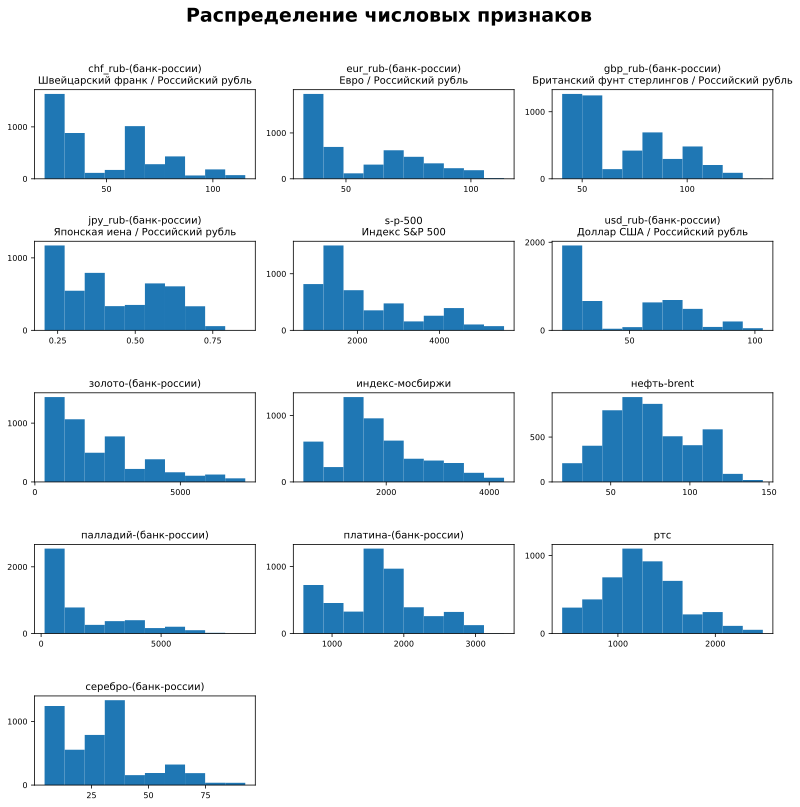

In [172]:
# Создаём полотно
plt.figure(figsize=[11, 13])

# Общий заголовок для всех графиков
plt.suptitle('Распределение числовых признаков ', 
                y=1.005, 
                fontsize=19, 
                fontweight='bold')

for i, col in enumerate(num_cols):
    plt.subplot(6, 3, i+1)
    # Заголовок для графика
    # Вставляем русский перевод если он есть, или оригинальное название
    explanations = col + '\n' + explanations_col[col] if explanations_col.get(col) else '\n' + col
    plt.title(f'\n{explanations}', fontsize=10)
    # Задаём размер шривта и угол поворота текста для осей X и Y
    plt.xticks(fontsize=8, rotation=0)
    plt.yticks(fontsize=8, rotation=0)
    # Делаем размер шрифта по Y=5, не уберая название оси
    plt.ylabel('', fontsize=5)
    # Отрисовываем гистограмму
    plt.hist(data_loaded[col])

# Автоматически уместить все элементы на полотне    
plt.tight_layout()

# Вывести графики на экран
plt.show()

### Предобработка признаков <a class='anchor' id='predobrabotka_'>

#### Посмотрим какие признаки имеют выбросы <a class='anchor' id='vibros_'>

In [173]:
def emission_test(ds, col_test, threshold_val=3, explanations_col=explanations_col):
    '''
    Функция проводит тестирование столбцов на выбросы методом Z-score.
    
    :param ds: исследуемый датасет,
    :param col_test: список колонок,
    :param threshold_val: пороговое значение Z-score,
    :param explanations_col: словарь признаков и их пояснения,
    :return: текстовый отчет и список выбросов.
    '''
    result = ''
    NUM = 2  # количество цифр после запятой
    outliers_list = [] # лист выбросов
    for col in col_test:
        # Вычисление Z-score
        z = np.abs(stats.zscore(ds[col]))
        # Установка порогового значения Z-score
        threshold = 3
        # Выявление выбросов на основе Z-score
        outliers = ds[col][z > threshold]
        
        if len(outliers) > 0:
            outliers_list.append(outliers)

            # Вставляем русский перевод если он есть, или оригинальное название
            explanations = f' ({explanations_col[col]})' if explanations_col.get(col) else ''
            
            result += f'В столбце {col}{explanations},\n{len(outliers)} выбросов. Mean: {round(ds[col].mean(), NUM)}, ' \
            f'Min: {round(ds[col].min(), NUM)}, Max: {round(ds[col].max(), NUM)}, ' \
            f'Moda: {round(ds[col].mode()[0], NUM)}, Median: {round(ds[col].median(), NUM)} \n\n'
    
    return f'Выбросов нет. ' if result == '' else result, outliers_list

In [174]:
def viev_outliers(outliers_list, col_name):
    '''
    Функция выводит строки датафрейма, в которых есть выбросы.
    
    :param outliers_list: список выбросов,
    :param col_name: название признака (фичи),
    :return: индексы выбросов.
    '''
    for item in outliers:
        if item.name == col_name:
            return item.index 

In [175]:
# Выведем признаки которые имеют выбросы
text_outliers, outliers = emission_test(ds=data_loaded, col_test=num_cols)

In [176]:
# Выведем текстовый отчёт по выбросам
print(text_outliers)

В столбце золото-(банк-россии),
23 выбросов. Mean: 2131.57, Min: 333.56, Max: 7231.12, Moda: 5993.16, Median: 1668.5 

В столбце палладий-(банк-россии),
22 выбросов. Mean: 1656.4, Min: 144.32, Max: 8507.4, Moda: 3275.71, Median: 795.39 

В столбце ртс,
6 выбросов. Mean: 1248.14, Min: 427.64, Max: 2487.92, Moda: 982.94, Median: 1209.7 

В столбце серебро-(банк-россии),
23 выбросов. Mean: 29.36, Min: 4.44, Max: 92.42, Moda: 32.11, Median: 30.17 




### Создание новых признаков <a class='anchor' id='new_priznak_'>

In [17]:
def choice_quarter(month):
    '''
    Функция определения квартала.

    :param month: номер месяца 1-12,
    :return: номер квартала 1-4, или -1, если ошибка.
    '''
    if month <= 3:
        return 1
    elif 4 <= month <= 6:
        return 2
    elif 7 <= month <= 9:    
        return 3
    elif 10 <= month <= 12:    
        return 4
    else:
        return -1

In [18]:
# Создадим дополнительные признаки (год, месяц, день, день недели (Пн-Вс), номер недели, квартал)
data_loaded['Year'] = data_loaded['Дата'].dt.year
data_loaded['Month'] = data_loaded['Дата'].dt.month
data_loaded['Weekday'] = data_loaded['Дата'].dt.weekday
data_loaded['Day'] = data_loaded['Дата'].dt.day
data_loaded['Week'] = data_loaded['Дата'].dt.isocalendar().week
data_loaded['Quarter'] = data_loaded['Month'].apply(lambda x: choice_quarter(x))

data_loaded.head()

,Дата,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии),Year,Month,Weekday,Day,Week,Quarter
0,2024-07-09,98.46,95.66,112.84,0.55,5576.98,88.17,6743.87,3054.07,84.66,2908.39,2899.89,1093.26,86.68,2024,7,1,9,28,3
1,2024-07-08,98.11,95.57,112.48,0.55,5572.85,88.13,6683.46,3132.58,85.64,2904.44,2867.60,1119.25,85.96,2024,7,0,8,28,3
2,2024-07-05,97.77,94.98,112.46,0.55,5567.19,88.12,6690.03,3149.29,86.97,2954.96,2835.97,1125.66,85.36,2024,7,4,5,27,3
3,2024-07-03,97.33,93.69,111.28,0.54,5537.02,87.99,6589.05,3203.07,86.63,2795.06,2786.57,1147.28,82.73,2024,7,2,3,27,3
4,2024-07-02,96.98,93.96,110.36,0.54,5509.01,87.30,6542.06,3217.29,86.24,2728.08,2840.35,1151.82,82.43,2024,7,1,2,27,3


### Проверка состояния данных <a class='anchor' id='data_status_'>

In [19]:
def not_correct_year(df=data_loaded, min_month=12, min_day=200):
    '''
    Функция выдает список не корректных годов, где min_month и min_day меньше заданного.

    :param  df: исследуемый датафрейм,
    :param  min_month: минимальное количество месяцев в году,
    :param  min_day: минимальное количество дней в году,
    :return: возвращает список не корректных годов и текстовый отчёт.
    '''

    not_corr_year = []
    txt_report = ''
    
    for year in df['Year'].unique():
        month_quantity = len(df[df['Year']==year]['Month'].unique())
        day_quantity = len(df[df['Year']==year]['Weekday'])
        if (month_quantity < min_month) or (day_quantity < min_day):
            not_corr_year.append(int(year))
        txt_report += f'Год: {year}, кол. месяцев: {month_quantity}, кол. дней: {day_quantity}\n'

    return not_corr_year, txt_report

In [20]:
# Протестируем датасет и запишем список не корректных годов и отчёт
not_correct_year_list, report = not_correct_year()
print(report)

Год: 2024, кол. месяцев: 7, кол. дней: 124
Год: 2023, кол. месяцев: 12, кол. дней: 237
Год: 2022, кол. месяцев: 12, кол. дней: 214
Год: 2021, кол. месяцев: 12, кол. дней: 233
Год: 2020, кол. месяцев: 12, кол. дней: 225
Год: 2019, кол. месяцев: 12, кол. дней: 232
Год: 2018, кол. месяцев: 12, кол. дней: 227
Год: 2017, кол. месяцев: 12, кол. дней: 232
Год: 2016, кол. месяцев: 12, кол. дней: 232
Год: 2015, кол. месяцев: 12, кол. дней: 231
Год: 2014, кол. месяцев: 12, кол. дней: 233
Год: 2013, кол. месяцев: 12, кол. дней: 232
Год: 2012, кол. месяцев: 12, кол. дней: 230
Год: 2011, кол. месяцев: 12, кол. дней: 232
Год: 2010, кол. месяцев: 12, кол. дней: 224
Год: 2009, кол. месяцев: 12, кол. дней: 230
Год: 2008, кол. месяцев: 12, кол. дней: 226
Год: 2007, кол. месяцев: 12, кол. дней: 227
Год: 2006, кол. месяцев: 12, кол. дней: 232
Год: 2005, кол. месяцев: 12, кол. дней: 231
Год: 2004, кол. месяцев: 12, кол. дней: 235
Год: 2003, кол. месяцев: 6, кол. дней: 123



### Метрика по которой будем оценивать качество работы модели <a class='anchor' id='metrika_'>

In [21]:
# Метрика
def mape(y_test, y_pred):
    '''
    Функция вычисляет ошибку в процентах от средних значений предсказанных и тестовых.

    :param  y_test: тестовые значения таргета,
    :param  y_pred: предсказанные значения таргета,
    :return: возвращает ошибку предсказания в процентах.
    '''
    return abs((y_test.mean() - y_pred.mean()) / y_pred.mean()) * 100

### Разбиение на временном ряду на train и test <a class='anchor' id='train_test_split_'>

In [22]:
def split_on_time_series(data, start_year, number_splits, type_split, target_name):
    '''
    Функция-генератор, разбивает на train и test, на временном ряду.

    :param  data: датафрем с данными,
    :param  start_year: год с которого будем разбивать,
    :param  number_splits: количество разбиений,
    :param  type_split: тип разбиений (Year, Quarter, Month, Week),
    :param  target_name: имя таргета (целевой переменной),
    :return: возвращает X_train, y_train, X_test, y_test, summary, time_point_test.
    '''
    # Удаляем все не латинские знаки, делаем первую букву заглавную, остальные обычные
    resample_param = re.sub(r'[^a-zA-z]', '', type_split).capitalize()
    resample_code = ''
    # Создадим список валют
    currency_list = [column for column in data if '_' in column]
    # Тригер первого включения
    triger = False
    
    # Выставляем параметр для сводной таблицы
    if resample_param == 'Year':
        resample_code = 'YE'
    elif resample_param == 'Quarter':
        resample_code = 'BQE'
    elif resample_param == 'Month':
        resample_code = 'ME'
    elif resample_param == 'Week':
        resample_code = 'W'    
    else:
        raise ValueError(f'Ошибка параметра "type_split={type_split}". Корректно: Year, Quarter, Month, Week') 

    # Делаем датафрем независимым
    df = data.copy(deep=True)
    # Сделаем резервную копию даты
    df['Дата-copy'] = df['Дата']
    # Установим столбец даты в качестве индекса
    df = df.set_index('Дата-copy')
    # Выберем данные после стартового года
    df = df.query(f'(Year >= {start_year})')

    # Создадим X_train и y_train
    # Делаем датафрем независимым
    X_train = data.copy(deep=True)
    X_train = X_train.query(f'(Year < {start_year})')
    # Установим столбец даты в качестве индекса
    X_train = X_train.set_index('Дата')
    # Создадим таргет
    y_train = X_train[target_name] 
    # Удалим все ненужные столбцы из X_train
    X_train.drop(columns=currency_list, axis=1, inplace=True)
    
    # Проверка
    n_row = df.resample(resample_code).count().shape[0]
    if n_row < number_splits:
        raise ValueError(f'Столько данных с параметрами "start_year={start_year}", не найдём ((')
    
    # Если всё ок разбиваем на train и test
    for row in range(number_splits):
        # Добавляем данные из предыдущего цикла, если он не первый
        if triger:
            X_train = pd.concat([X_train, X_test])
            y_train = pd.concat([y_train, y_test])
        else:
            triger = True
        # Читаем строчку сводной таблицы
        pivot_table_row = pd.DataFrame(df.resample(resample_code).mean().iloc[row]).T[['Year', resample_param]]
        # Соединяем таблицу и строку сводной таблицы
        result = df.merge(pivot_table_row, on=['Year', resample_param], how='right')
        result = result.set_index('Дата')
        # Запишем таргет в отдельную переменную
        y_test = result[target_name]
        # Удалим все таргеты из датасета
        result.drop(columns=currency_list, axis=1, inplace=True)
        X_test = result
        # Инфа по данным
        summary = f'Train({X_train.index.min().strftime('%d.%m.%Y')}-{X_train.index.max().strftime('%d.%m.%Y')}, X.shape{X_train.shape}, y.shape{y_train.shape}), ' \
                  f'Test({X_test.index.min().strftime('%d.%m.%Y')}-{X_test.index.max().strftime('%d.%m.%Y')}, X.shape{X_test.shape}, y.shape{y_test.shape})'
        # Запишем переменные времени, для графика
        time_point_test = X_test.index.max()
        
        
        yield X_train, y_train, X_test, y_test, summary, time_point_test


### Функция кросс-валидации <a class='anchor' id='cross_val_'>

In [23]:
def cross_validation_time_series(model, df, year, n_split, type_split, currency, cv_info):
    '''
    Функция кросс-валидирует список валют на временном ряду.

    :param  model: ML модель которую будем использовать для кросс-валидации,
    :param  df: датафрейм с данными,
    :param  year: год с которого нужно начать кросс-валидацию,
    :param  n_split: число кросс-валидаций,
    :param  type_split: тип кросс валидаций (Year, Quarter, Month, Week),
    :param  currency: список полей валют,
    :param  cv_info: файл pandas куда будет записываться статистика о кросс-валидациях,
    :return: возвращает фал статистики кросс-валидаций.    
    '''
    for currency_item in currency:
        for  X_train, y_train, X_test, y_test, summary, time_point_test in split_on_time_series(df, year, n_split, type_split, currency_item):
            # Обучим модель
            model.fit(X_train, y_train)
            # Выполним предикт
            y_pred = model.predict(X_test)
            # Посмотрим эффективность модели 
            cv_error = mape(y_test, y_pred)
            # Запишем статистику кросс валидации
            cv_info.loc[len(cv_info)]  = {'date':time_point_test, 'currency':currency_item, 'type_split':type_split, 'error':cv_error}
            # Сделал, чтобы выводилась статистика о ходе процесса
            print(f'{summary}, \nОшибка: {round(cv_error, 2)} %,  Валюта: {re.sub(r'[^a-zA-z_]', '', currency_item)}\n')

    return cv_info

### Создание модели и дата фрейма для хранения результатов кросс-валидации <a class='anchor' id='model_df_'>

In [ ]:
# Создадим модель с количеством деревьев в лесу 2000, с максимальной глубиной залегания дерева 21 (эти параметры подобрал с помощью GridSearchCV)
rf_model = RandomForestRegressor(n_estimators=2000, max_depth=21, random_state=42, criterion='squared_error')
# Обновим список валют
currency_list = [column for column in data_loaded if '_' in column]
# Датафрейм статистики кросс-валидации
cv_info = pd.DataFrame({'date':[], 'currency':[], 'type_split':[], 'error':[]})

### Кросс-валидация данных <a class='anchor' id='cross_val_data_'>

#### С шагом в год <a class='anchor' id='year_'>

In [ ]:
%%time
# Будем кросвалидировать 10 раз по году
cv_info = cross_validation_time_series(rf_model, data_loaded, 2013, 10, 'Year', currency_list, cv_info)

#### С шагом в квартал <a class='anchor' id='quarter_'>

In [ ]:
%%time
# Будем кросвалидировать 10 раз по кварталу
cv_info = cross_validation_time_series(rf_model, data_loaded, 2022, 10, 'Quarter', currency_list, cv_info)

#### С шагом в месяц <a class='anchor' id='month_'>

In [ ]:
%%time
# Будем кросвалидировать 10 раз по месяцу
cv_info = cross_validation_time_series(rf_model, data_loaded, 2023, 10, 'Month', currency_list, cv_info)

#### С шагом в неделю <a class='anchor' id='week_'>

In [ ]:
%%time
# Будем кросвалидировать 10 раз по недели
cv_info = cross_validation_time_series(rf_model, data_loaded, 2024, 10, 'Week', currency_list, cv_info)

### Визуализация результатов кросс-валидации <a class='anchor' id='visual_cross_val_'>

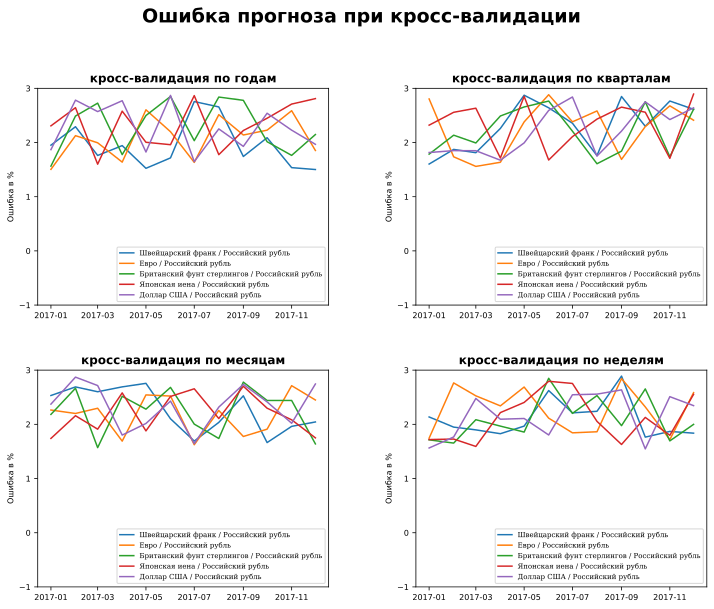

In [130]:
# Стиль легенды
legend_font = {
    "size": 7,
    "family": "serif",
}
# Стиль заголовков
title_font = {
    "fontsize": 12,
    "fontweight": "bold"
}

# Обновим список валют (на всякий случай)
currency_list = [column for column in data_loaded if '_' in column]

# Задаём размер полотна
plt.figure(figsize=[12, 9])

# Общий заголовок для всех графиков
plt.suptitle('Ошибка прогноза при кросс-валидации', 
               y=1.005, 
               fontsize=19, 
               fontweight='bold')

# Строим 4-е графика 2х2
for i, type_split_item in enumerate(cv_info['type_split'].unique()):
    plt.subplot(2, 2, i+1)
    # Заголовок для графика
    split_type_dict = {
        'Year': 'годам',
        'Quarter':'кварталам',
        'Month':'месяцам',
        'Week':'неделям'}
    plt.title(f'кросс-валидация по {split_type_dict[type_split_item]}', fontdict=title_font)
    # Задаём размер шривта и угол поворота текста для осей X и Y
    plt.xticks(fontsize=8, rotation=0)
    plt.yticks(fontsize=8, rotation=0)
    # Делаем размер шрифта по Y=8
    plt.ylabel('Ошибка в %', fontsize=8)
    # Задаём границы графика
    plt.ylim(-1, 3)
    # Задаём расстояние меду графиками
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    # Отрисовываем графики
    for currency_item in currency_list:     
        # Создаём датафрем по условию валюты и типа разбиения (год, месяц и тд.)
        df_temp = cv_info.query(f'(currency == "{currency_item}") & (type_split == "{type_split_item}")')
        # Запишем переменные в x и y
        x = df_temp['date']
        y = df_temp['error']
        # Вставляем русский перевод если он есть, или оригинал, если перевода нет
        legend_text = explanations_col[currency_item] if explanations_col.get(currency_item) else currency_item
        # Отрисовываем график и легенду
        plt.plot(x, y, label=legend_text)
        # Выставляем стиль и положение легенды
        plt.legend(loc="lower right", prop=legend_font)
        
# Вывести графики на экран
plt.show()

### Сохранение результатов кросс-валидации в файл CSV <a class='anchor' id='report_cross_val_'>

In [178]:
cv_info.to_csv('output.csv')

In [ ]:
# # Датафрейм статистики кросс-валидации
# import random

# cv_info = pd.DataFrame({'date':[], 'currency':[], 'type_split':[], 'error':[]})
# currency_list = [column for column in data_loaded if '_' in column]
# type_split_list = ['Year', 'Quarter', 'Month', 'Week']

# for type_split_item in type_split_list:
#     for i in range(12):
#         for currency_item in currency_list:
#             time_stamp = pd.Timestamp(f'2017-{i+1}-01')
#             error = random.uniform(1.5, 2.9)
#             cv_info.loc[len(cv_info)]  = {'date':time_stamp, 'currency':currency_item, 'type_split':type_split_item, 'error':error}

### Прогнозирование на тестовом датасете <a class='anchor' id='prognoz'>

### Вывод: <a class='anchor' id='vivod'>
.
